## Deep Learning Term Project for ECG (DIL700)

# Iteration 5

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
from keras import Sequential
from keras.layers import Convolution1D, MaxPool1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings('ignore')

import datetime

# Custom functions
from general_functions import *

# Loading dataset

    Number of Samples: 14552
    Number of Categories: 2
    Sampling Frequency: 125Hz
    Data Source: Physionet's PTB Diagnostic Database

This dataset consists of a series of CSV files. Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs. (https://www.kaggle.com/datasets/shayanfazeli/heartbeat)

In [2]:
normal_df = pd.read_csv('./Dataset_ptbdb/ptbdb_normal.csv',header=None)
abnormal_df = pd.read_csv('./Dataset_ptbdb/ptbdb_abnormal.csv',header=None)
# Combine to a full dataset
full_df = pd.concat([normal_df, abnormal_df], axis=0, ignore_index=True)

In [3]:
print('Number of samples per class: \n')
print('Normal:                 ', len(full_df[full_df[187]==0]))
print('Abnormal:               ', len(full_df[full_df[187]==1]))

Number of samples per class: 

Normal:                  4046
Abnormal:                10506


In [4]:
normal_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,1.000000,0.929586,0.503550,0.293491,0.169822,0.159763,0.130769,0.125444,0.137278,0.111243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4042,1.000000,0.637579,0.154837,0.061983,0.088965,0.083374,0.065143,0.057365,0.060039,0.060039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4043,1.000000,0.872574,0.465071,0.232212,0.126132,0.155886,0.174644,0.190168,0.203752,0.168823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4044,0.915983,0.529373,0.288406,0.144536,0.171802,0.180669,0.177566,0.176458,0.178896,0.180448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Normal only contains class 0 --> healthy
normal_df[187].unique()

array([0.])

In [6]:
abnormal_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10502,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10503,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10504,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
# Abnormal only contains class 1 --> not healthy
abnormal_df[187].unique()

array([1.])

In [8]:
full_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14547,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14548,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14549,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14550,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
# Full contains both classes
full_df[187].unique()

array([0., 1.])

In [10]:
labels = ['Normal', 'Abnormal']

# Preparation

In [11]:
from sklearn.model_selection import train_test_split

# split the data into features and target
X = full_df.drop(187, axis=1)
y = full_df[187]

# Split data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [12]:
# validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=42)

In [13]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
12529,1.000000,0.829819,0.467386,0.203531,0.208926,0.182442,0.073075,0.078470,0.067680,0.049044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
8792,0.905602,0.734440,0.354772,0.154046,0.122925,0.165975,0.176349,0.177905,0.182054,0.176867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
13408,1.000000,0.808531,0.117995,0.109900,0.061021,0.031756,0.022416,0.011519,0.006849,0.027086,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2746,1.000000,0.529361,0.199217,0.094824,0.107873,0.109178,0.088734,0.079600,0.074815,0.075685,...,0.052197,0.055676,0.055676,0.057851,0.060896,0.067856,0.066551,0.0,0.0,0.0
366,1.000000,0.700711,0.349063,0.106658,0.077569,0.301228,0.371041,0.371687,0.404008,0.411765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13768,0.888561,0.430425,0.423939,0.391509,0.364976,0.339623,0.290094,0.295401,0.312500,0.303066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
5609,1.000000,0.338724,0.017969,0.000000,0.415993,0.477987,0.510332,0.546271,0.587601,0.543576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2442,1.000000,0.551974,0.231668,0.007252,0.023368,0.076551,0.101128,0.092264,0.089847,0.087429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
11291,0.988811,0.376690,0.000000,0.014918,0.049417,0.059207,0.076457,0.055478,0.035431,0.037296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [14]:
train_df = X_train.copy()
train_df[187] = y_train
valid_df = X_valid.copy()
valid_df[187] = y_valid
test_df = X_test.copy()	
test_df[187] = y_test

train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
12529,1.000000,0.829819,0.467386,0.203531,0.208926,0.182442,0.073075,0.078470,0.067680,0.049044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
8792,0.905602,0.734440,0.354772,0.154046,0.122925,0.165975,0.176349,0.177905,0.182054,0.176867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
13408,1.000000,0.808531,0.117995,0.109900,0.061021,0.031756,0.022416,0.011519,0.006849,0.027086,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2746,1.000000,0.529361,0.199217,0.094824,0.107873,0.109178,0.088734,0.079600,0.074815,0.075685,...,0.055676,0.055676,0.057851,0.060896,0.067856,0.066551,0.0,0.0,0.0,0.0
366,1.000000,0.700711,0.349063,0.106658,0.077569,0.301228,0.371041,0.371687,0.404008,0.411765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13768,0.888561,0.430425,0.423939,0.391509,0.364976,0.339623,0.290094,0.295401,0.312500,0.303066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
5609,1.000000,0.338724,0.017969,0.000000,0.415993,0.477987,0.510332,0.546271,0.587601,0.543576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2442,1.000000,0.551974,0.231668,0.007252,0.023368,0.076551,0.101128,0.092264,0.089847,0.087429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
11291,0.988811,0.376690,0.000000,0.014918,0.049417,0.059207,0.076457,0.055478,0.035431,0.037296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0


In [15]:
print('Number of samples in training data:')
print('Normal:                              ', len(train_df[train_df[187]==0]))
print('Abnormal:                            ', len(train_df[train_df[187]==1]))

Number of samples in training data:
Normal:                               2589
Abnormal:                             6723


In [16]:
print('Number of samples in validation data:')
print('Normal:                              ', len(valid_df[valid_df[187]==0]))
print('Abnormal:                            ', len(valid_df[valid_df[187]==1]))

Number of samples in validation data:
Normal:                               648
Abnormal:                             1681


In [17]:
print('Number of samples in test data:')
print('Normal:                              ', len(test_df[test_df[187]==0]))
print('Abnormal:                            ', len(test_df[test_df[187]==1]))

Number of samples in test data:
Normal:                               809
Abnormal:                             2102


Same ratio of the two classes in both the datasets

# ANN

# To beat

CM of ANN with optimisation of hyperparameters

773 &emsp;&emsp;36

21  &emsp;&emsp;2081

# Dropout with Rate 0.08

In [26]:
name = 'ann_dropout_008'

In [27]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.Dropout(rate=0.08))
    # AlphaDropout
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 2s 4ms/step - loss: 0.4620 - accuracy: 0.7746 - val_loss: 0.3453 - val_accuracy: 0.8411
Epoch 2/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3765 - accuracy: 0.8227 - val_loss: 0.3189 - val_accuracy: 0.8622
Epoch 3/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3445 - accuracy: 0.8396 - val_loss: 0.2897 - val_accuracy: 0.8682
Epoch 4/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3060 - accuracy: 0.8620 - val_loss: 0.2635 - val_accuracy: 0.8841
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2895 - accuracy: 0.8723 - val_loss: 0.2678 - val_accuracy: 0.8836
Epoch 6/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2765 - accuracy: 0.8791 - val_loss: 0.2318 - val_accuracy: 0.9008
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2609 - accuracy: 0.8881 - val_loss: 0.2935 - val_accuracy: 0.8712

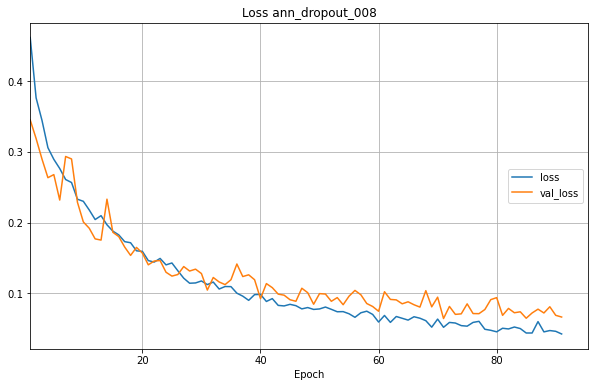

In [29]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

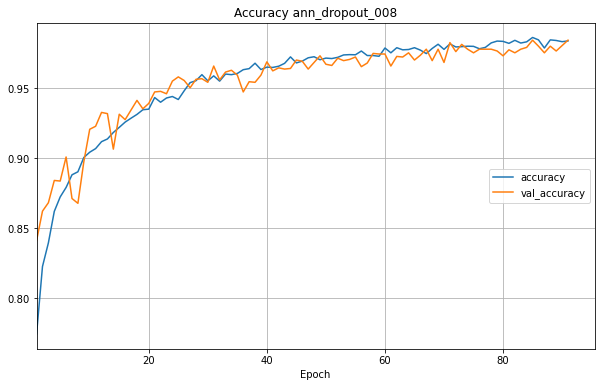

In [30]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [31]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.97733


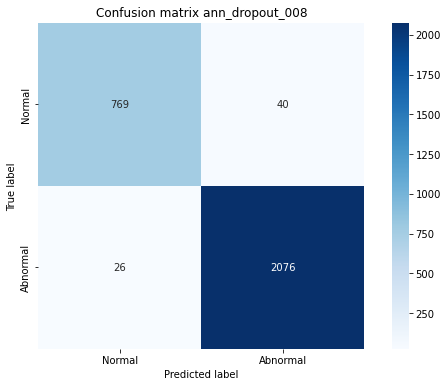

In [32]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [33]:
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9673    0.9506    0.9589       809
    Abnormal     0.9811    0.9876    0.9844      2102

    accuracy                         0.9773      2911
   macro avg     0.9742    0.9691    0.9716      2911
weighted avg     0.9773    0.9773    0.9773      2911



# Dropout with Rate 0.10

In [18]:
name = 'ann_dropout_010'

In [19]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.Dropout(rate=0.10))
    # AlphaDropout
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 2s 4ms/step - loss: 0.4560 - accuracy: 0.7749 - val_loss: 0.3606 - val_accuracy: 0.8373
Epoch 2/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3857 - accuracy: 0.8185 - val_loss: 0.3212 - val_accuracy: 0.8609
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3584 - accuracy: 0.8360 - val_loss: 0.3324 - val_accuracy: 0.8484
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3259 - accuracy: 0.8514 - val_loss: 0.2748 - val_accuracy: 0.8836
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3024 - accuracy: 0.8609 - val_loss: 0.2787 - val_accuracy: 0.8781
Epoch 6/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2885 - accuracy: 0.8719 - val_loss: 0.2614 - val_accuracy: 0.8815
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2712 - accuracy: 0.8790 - val_loss: 0.2428 - val_accuracy: 0.8935

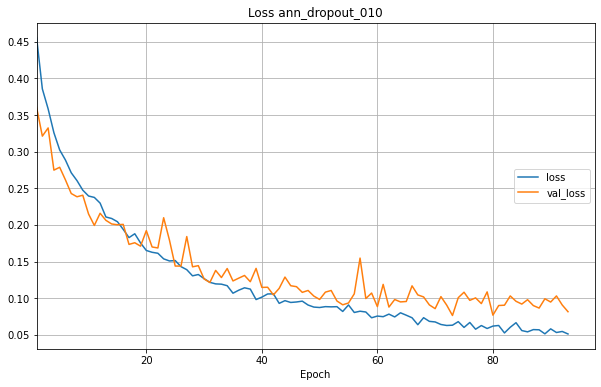

In [21]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

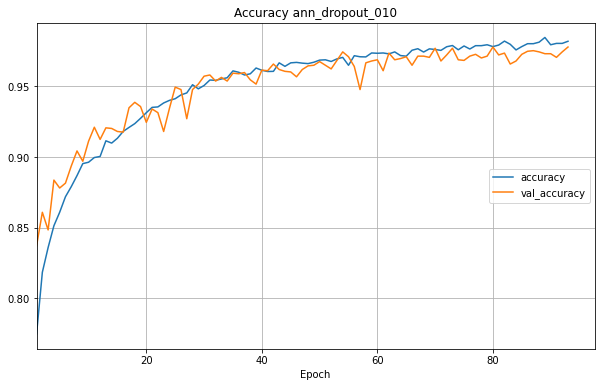

In [22]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [23]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.97492


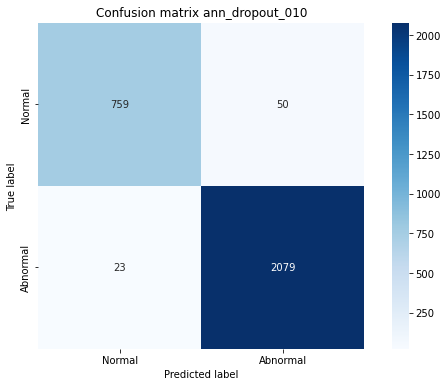

In [24]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [25]:
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9706    0.9382    0.9541       809
    Abnormal     0.9765    0.9891    0.9827      2102

    accuracy                         0.9749      2911
   macro avg     0.9736    0.9636    0.9684      2911
weighted avg     0.9749    0.9749    0.9748      2911



# Dropout with Rate 0.12

In [26]:
name = 'ann_dropout_012'

In [27]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.Dropout(rate=0.12))
    # AlphaDropout
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')


Epoch 1/100
291/291 [==============================] - 2s 3ms/step - loss: 0.4613 - accuracy: 0.7751 - val_loss: 0.3627 - val_accuracy: 0.8347
Epoch 2/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3894 - accuracy: 0.8164 - val_loss: 0.3237 - val_accuracy: 0.8574
Epoch 3/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3579 - accuracy: 0.8312 - val_loss: 0.3223 - val_accuracy: 0.8420
Epoch 4/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3353 - accuracy: 0.8454 - val_loss: 0.2900 - val_accuracy: 0.8699
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3102 - accuracy: 0.8623 - val_loss: 0.2693 - val_accuracy: 0.8824
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 0.2998 - accuracy: 0.8702 - val_loss: 0.2582 - val_accuracy: 0.8909
Epoch 7/100
291/291 [==============================] - 1s 2ms/step - loss: 0.2845 - accuracy: 0.8774 - val_loss: 0.2743 - val_accuracy: 0.8781

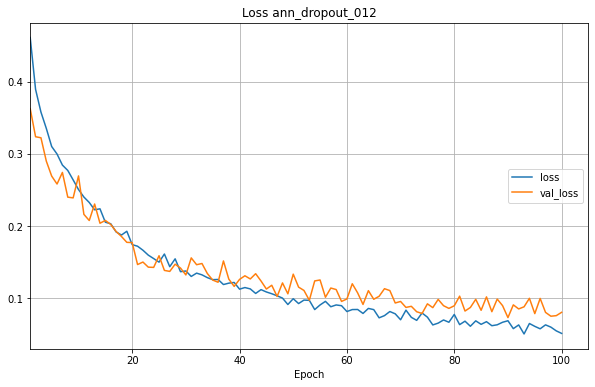

In [29]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

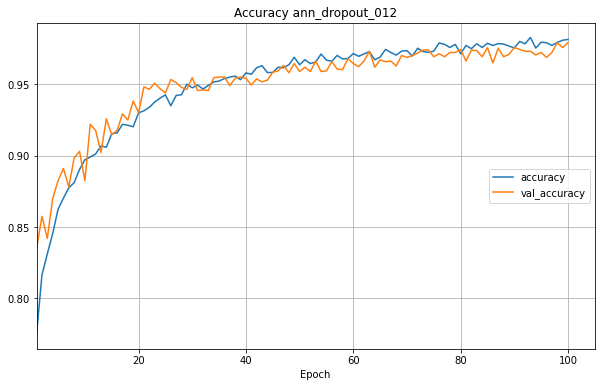

In [30]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [31]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.97527


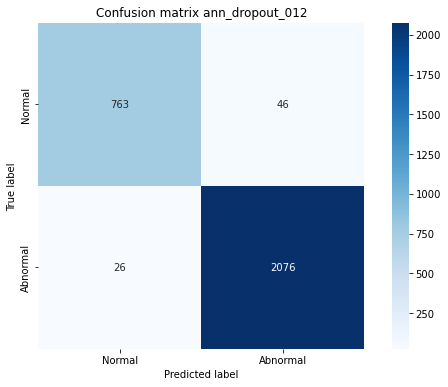

In [32]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [33]:
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9670    0.9431    0.9549       809
    Abnormal     0.9783    0.9876    0.9830      2102

    accuracy                         0.9753      2911
   macro avg     0.9727    0.9654    0.9689      2911
weighted avg     0.9752    0.9753    0.9752      2911



# Dropout with Rate 0.14

In [34]:
name = 'ann_dropout_014'

In [35]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.Dropout(rate=0.14))
    # AlphaDropout
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')


Epoch 1/100
291/291 [==============================] - 2s 3ms/step - loss: 0.4801 - accuracy: 0.7581 - val_loss: 0.3920 - val_accuracy: 0.8055
Epoch 2/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4119 - accuracy: 0.7970 - val_loss: 0.3614 - val_accuracy: 0.8295
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3826 - accuracy: 0.8172 - val_loss: 0.3341 - val_accuracy: 0.8398
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3480 - accuracy: 0.8359 - val_loss: 0.3017 - val_accuracy: 0.8716
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3295 - accuracy: 0.8495 - val_loss: 0.2878 - val_accuracy: 0.8755
Epoch 6/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3155 - accuracy: 0.8558 - val_loss: 0.2694 - val_accuracy: 0.8703
Epoch 7/100
291/291 [==============================] - 1s 2ms/step - loss: 0.2980 - accuracy: 0.8680 - val_loss: 0.2607 - val_accuracy: 0.8866

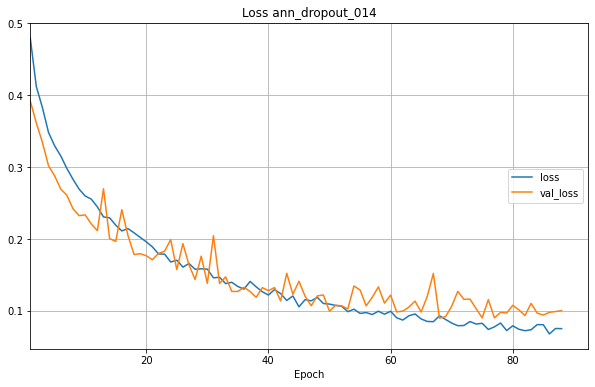

In [37]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

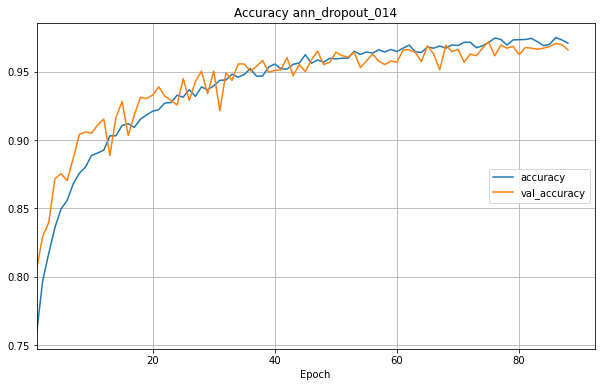

In [38]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [39]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.96943


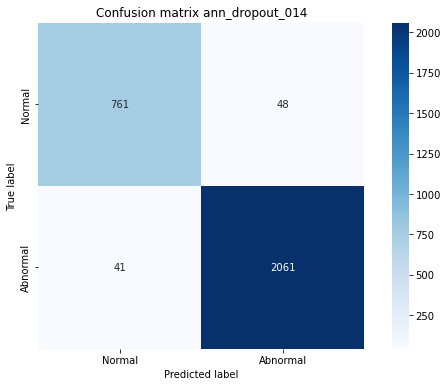

In [40]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [41]:
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9489    0.9407    0.9448       809
    Abnormal     0.9772    0.9805    0.9789      2102

    accuracy                         0.9694      2911
   macro avg     0.9631    0.9606    0.9618      2911
weighted avg     0.9694    0.9694    0.9694      2911



# AlphaDropout with Rate 0.10

Alpha dropout remains bad, even if the rate is optimized.

In [18]:
name = 'ann_alphadropout_010'

In [19]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.AlphaDropout(rate=0.10))
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')


Epoch 1/100
291/291 [==============================] - 3s 4ms/step - loss: 0.5548 - accuracy: 0.7208 - val_loss: 0.4207 - val_accuracy: 0.7952
Epoch 2/100
291/291 [==============================] - 1s 4ms/step - loss: 0.4485 - accuracy: 0.7658 - val_loss: 0.4166 - val_accuracy: 0.7969
Epoch 3/100
291/291 [==============================] - 1s 4ms/step - loss: 0.4235 - accuracy: 0.7762 - val_loss: 0.3771 - val_accuracy: 0.8029
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 0.4051 - accuracy: 0.7845 - val_loss: 0.4099 - val_accuracy: 0.7943
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3978 - accuracy: 0.7955 - val_loss: 0.3667 - val_accuracy: 0.8188
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3800 - accuracy: 0.8111 - val_loss: 0.3470 - val_accuracy: 0.8334
Epoch 7/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3638 - accuracy: 0.8166 - val_loss: 0.3329 - val_accuracy: 0.8502

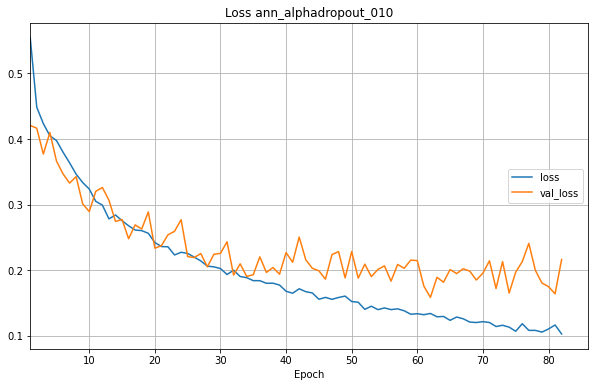

In [21]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

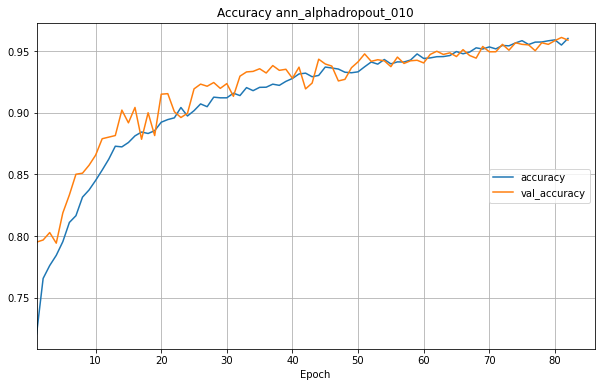

In [22]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [23]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.93885


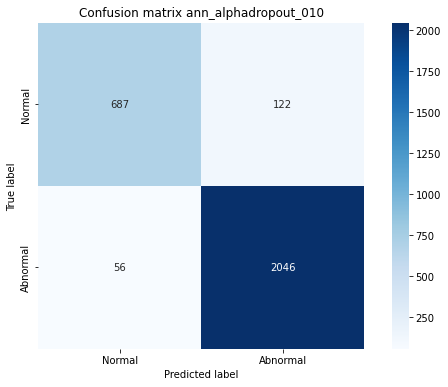

In [24]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [25]:
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9246    0.8492    0.8853       809
    Abnormal     0.9437    0.9734    0.9583      2102

    accuracy                         0.9389      2911
   macro avg     0.9342    0.9113    0.9218      2911
weighted avg     0.9384    0.9389    0.9380      2911



# Batch Normalization

In [34]:
name = 'ann_batch_norm'

In [35]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]

# model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1])))
# model.add(tf.keras.layers.BatchNormalization())

# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], input_dim=X_train.shape[1]))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(activation_function))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i]))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(activation_function))
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 3s 5ms/step - loss: 0.4282 - accuracy: 0.8027 - val_loss: 0.3554 - val_accuracy: 0.8553
Epoch 2/100
291/291 [==============================] - 1s 4ms/step - loss: 0.3183 - accuracy: 0.8648 - val_loss: 0.2989 - val_accuracy: 0.8605
Epoch 3/100
291/291 [==============================] - 1s 4ms/step - loss: 0.2750 - accuracy: 0.8826 - val_loss: 0.2312 - val_accuracy: 0.9094
Epoch 4/100
291/291 [==============================] - 1s 4ms/step - loss: 0.2509 - accuracy: 0.8943 - val_loss: 0.2514 - val_accuracy: 0.9017
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2328 - accuracy: 0.9008 - val_loss: 0.2223 - val_accuracy: 0.9171
Epoch 6/100
291/291 [==============================] - 1s 5ms/step - loss: 0.2058 - accuracy: 0.9144 - val_loss: 0.1828 - val_accuracy: 0.9266
Epoch 7/100
291/291 [==============================] - 1s 4ms/step - loss: 0.1947 - accuracy: 0.9190 - val_loss: 0.1754 - val_accuracy: 0.9360

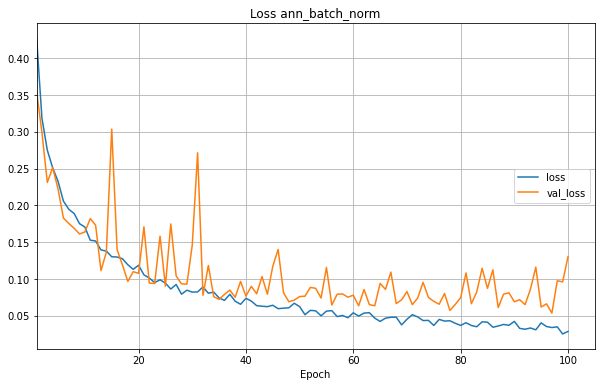

In [37]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

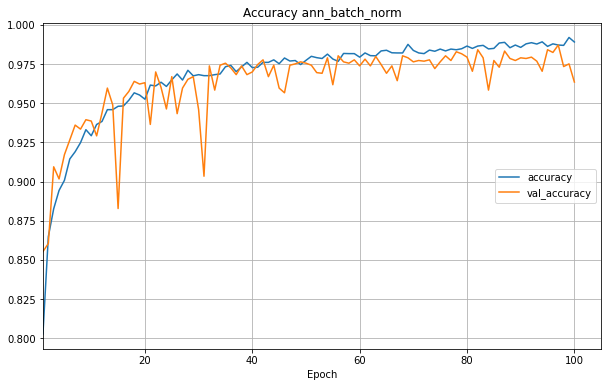

In [38]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [42]:
# Predict test set labels
y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

91/91 [==============================] - 0s 2ms/step
Accuracy: 0.98248


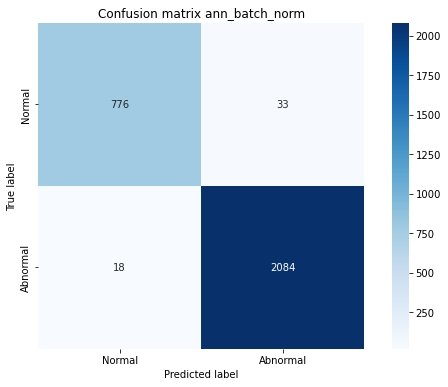

In [40]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [41]:
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9773    0.9592    0.9682       809
    Abnormal     0.9844    0.9914    0.9879      2102

    accuracy                         0.9825      2911
   macro avg     0.9809    0.9753    0.9780      2911
weighted avg     0.9824    0.9825    0.9824      2911



# Batch Normalization - BN before first dense layer

In [43]:
name = 'ann_batch_norm_input'

In [46]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]

# model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1])))
model.add(tf.keras.layers.BatchNormalization())

# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], input_dim=X_train.shape[1]))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(activation_function))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i]))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(activation_function))
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 4s 5ms/step - loss: 0.4467 - accuracy: 0.7903 - val_loss: 0.3663 - val_accuracy: 0.8407
Epoch 2/100
291/291 [==============================] - 1s 4ms/step - loss: 0.3246 - accuracy: 0.8601 - val_loss: 0.2659 - val_accuracy: 0.9038
Epoch 3/100
291/291 [==============================] - 1s 4ms/step - loss: 0.2835 - accuracy: 0.8748 - val_loss: 0.2491 - val_accuracy: 0.9017
Epoch 4/100
291/291 [==============================] - 1s 4ms/step - loss: 0.2559 - accuracy: 0.8920 - val_loss: 0.2082 - val_accuracy: 0.9219
Epoch 5/100
291/291 [==============================] - 1s 4ms/step - loss: 0.2358 - accuracy: 0.9026 - val_loss: 0.1896 - val_accuracy: 0.9365
Epoch 6/100
291/291 [==============================] - 1s 4ms/step - loss: 0.2197 - accuracy: 0.9082 - val_loss: 0.1976 - val_accuracy: 0.9210
Epoch 7/100
291/291 [==============================] - 1s 4ms/step - loss: 0.1975 - accuracy: 0.9203 - val_loss: 0.1491 - val_accuracy: 0.9502

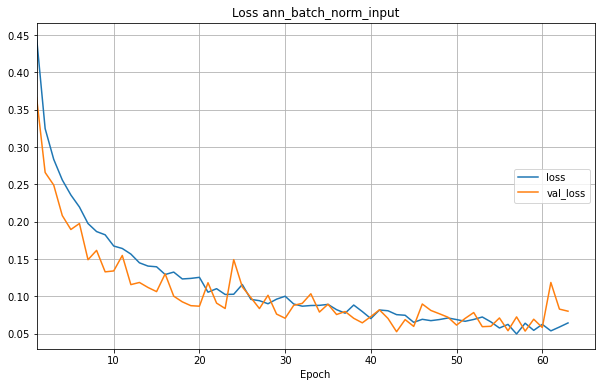

In [48]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

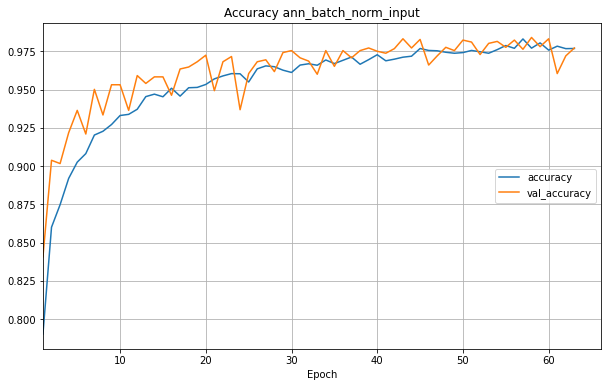

In [49]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [53]:
# Predict test set labels
y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

91/91 [==============================] - 0s 1ms/step
Accuracy: 0.98179


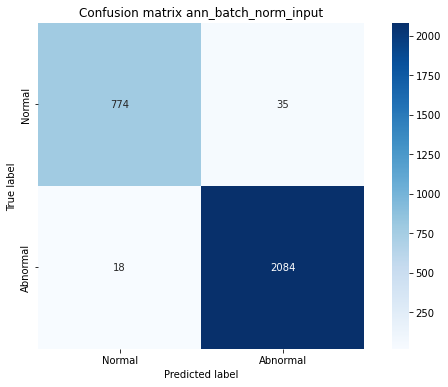

In [54]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [55]:
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9773    0.9567    0.9669       809
    Abnormal     0.9835    0.9914    0.9874      2102

    accuracy                         0.9818      2911
   macro avg     0.9804    0.9741    0.9772      2911
weighted avg     0.9818    0.9818    0.9817      2911



# CNN

# To beat

CM of CNN with optimisation of hyperparameters

797 &emsp;&emsp;12

6  &emsp;&emsp;2096

# Batch Normalization - moved activation function

In [18]:
name = 'cnn_batch_norm_move_af'

In [19]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), input_shape=(X_train.shape[1],1)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
    else:
        model.add(Convolution1D(64, (masked_kernels[i])))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons, activation='relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 10s 30ms/step - loss: 0.2932 - accuracy: 0.8739 - val_loss: 0.4243 - val_accuracy: 0.7840
Epoch 2/100
291/291 [==============================] - 8s 28ms/step - loss: 0.1256 - accuracy: 0.9555 - val_loss: 0.3975 - val_accuracy: 0.8231
Epoch 3/100
291/291 [==============================] - 8s 29ms/step - loss: 0.0790 - accuracy: 0.9730 - val_loss: 1.1441 - val_accuracy: 0.7518
Epoch 4/100
291/291 [==============================] - 8s 28ms/step - loss: 0.0512 - accuracy: 0.9825 - val_loss: 0.0526 - val_accuracy: 0.9811
Epoch 5/100
291/291 [==============================] - 8s 28ms/step - loss: 0.0487 - accuracy: 0.9815 - val_loss: 0.0474 - val_accuracy: 0.9841
Epoch 6/100
291/291 [==============================] - 8s 29ms/step - loss: 0.0410 - accuracy: 0.9858 - val_loss: 1.2319 - val_accuracy: 0.7870
Epoch 7/100
291/291 [==============================] - 8s 28ms/step - loss: 0.0341 - accuracy: 0.9886 - val_loss: 0.4342 - val_accuracy

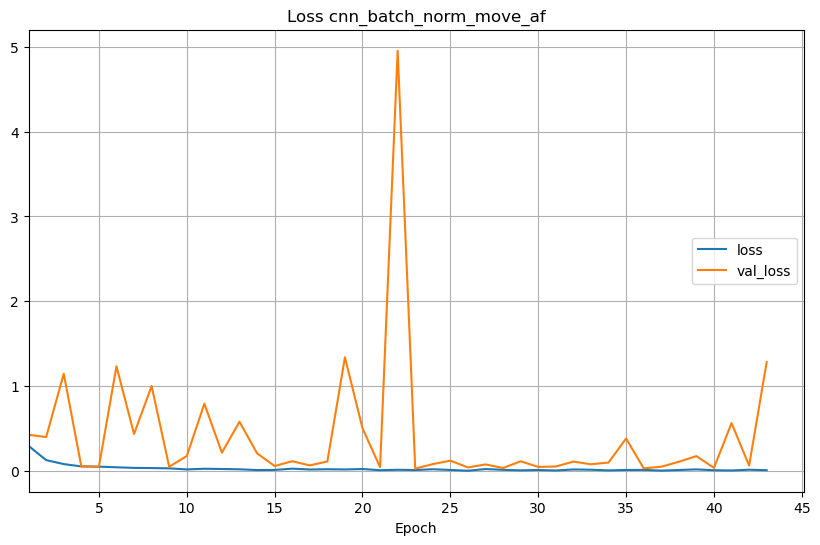

In [21]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

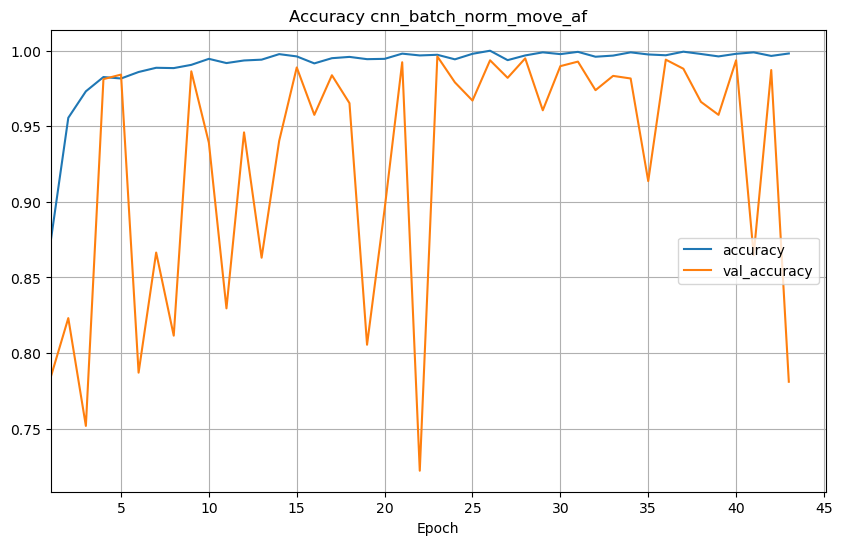

In [22]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [23]:
# Predict test set labels
y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

91/91 [==============================] - 1s 10ms/step
Accuracy: 0.99210


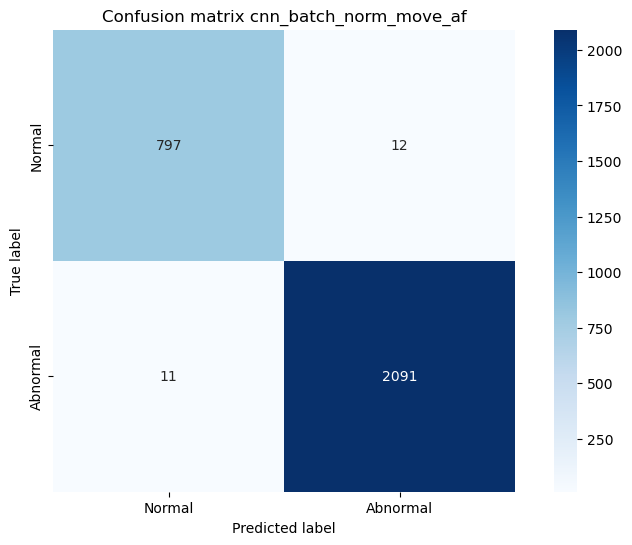

In [24]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [25]:
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9864    0.9852    0.9858       809
    Abnormal     0.9943    0.9948    0.9945      2102

    accuracy                         0.9921      2911
   macro avg     0.9903    0.9900    0.9902      2911
weighted avg     0.9921    0.9921    0.9921      2911



# Batch Normalization - added for dense layers

In [47]:
name = 'cnn_batch_norm_dense'

In [48]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), input_shape=(X_train.shape[1],1)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
    else:
        model.add(Convolution1D(64, (masked_kernels[i])))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 10s 31ms/step - loss: 0.2512 - accuracy: 0.8963 - val_loss: 0.5059 - val_accuracy: 0.7261
Epoch 2/100
291/291 [==============================] - 9s 29ms/step - loss: 0.1056 - accuracy: 0.9599 - val_loss: 0.2962 - val_accuracy: 0.8652
Epoch 3/100
291/291 [==============================] - 9s 32ms/step - loss: 0.0691 - accuracy: 0.9764 - val_loss: 0.1235 - val_accuracy: 0.9489
Epoch 4/100
291/291 [==============================] - 9s 32ms/step - loss: 0.0514 - accuracy: 0.9826 - val_loss: 1.2752 - val_accuracy: 0.7518
Epoch 5/100
291/291 [==============================] - 9s 30ms/step - loss: 0.0494 - accuracy: 0.9843 - val_loss: 1.1760 - val_accuracy: 0.7501
Epoch 6/100
291/291 [==============================] - 9s 32ms/step - loss: 0.0353 - accuracy: 0.9873 - val_loss: 0.5123 - val_accuracy: 0.8429
Epoch 7/100
291/291 [==============================] - 9s 30ms/step - loss: 0.0276 - accuracy: 0.9894 - val_loss: 0.3876 - val_accuracy

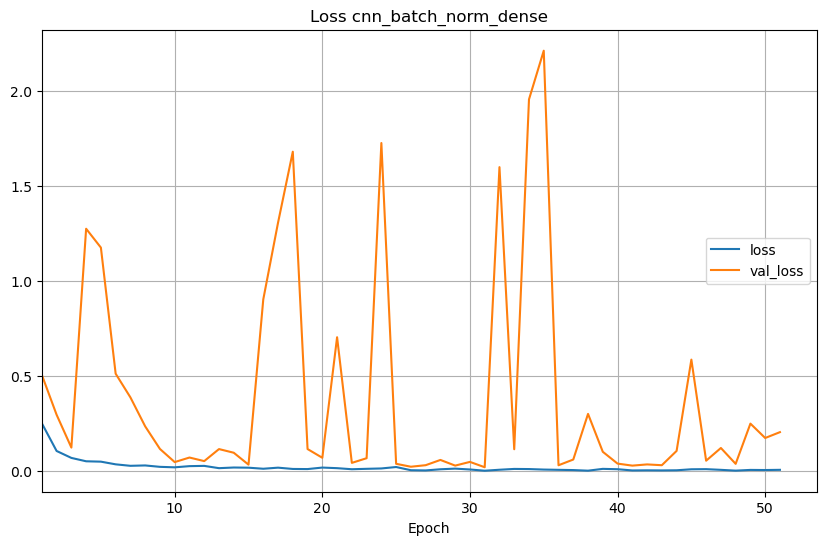

In [50]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

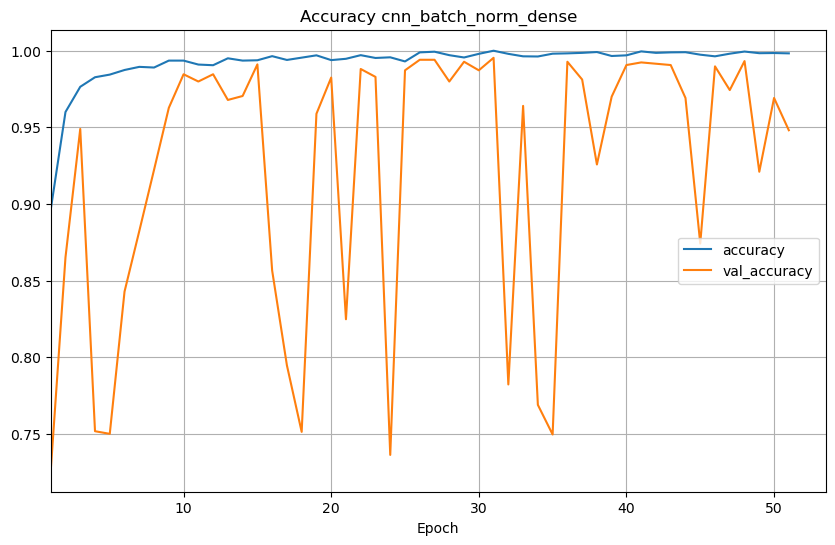

In [51]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [52]:
# Predict test set labels
y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

91/91 [==============================] - 1s 12ms/step
Accuracy: 0.99450


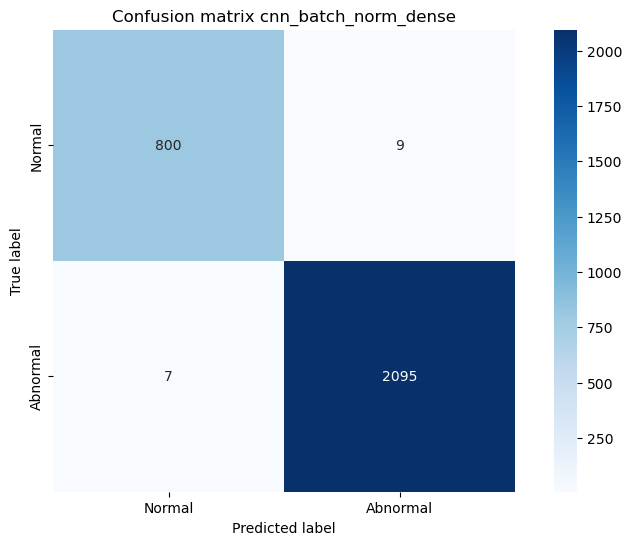

In [53]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [54]:
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9913    0.9889    0.9901       809
    Abnormal     0.9957    0.9967    0.9962      2102

    accuracy                         0.9945      2911
   macro avg     0.9935    0.9928    0.9931      2911
weighted avg     0.9945    0.9945    0.9945      2911



# Batch Normalization - added for dense layers, original order of activation function

In [55]:
name = 'cnn_batch_norm_dense_actback'

In [56]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
        model.add(tf.keras.layers.BatchNormalization())
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 10s 30ms/step - loss: 0.2264 - accuracy: 0.9125 - val_loss: 1.0981 - val_accuracy: 0.7218
Epoch 2/100
291/291 [==============================] - 9s 30ms/step - loss: 0.0966 - accuracy: 0.9660 - val_loss: 0.7105 - val_accuracy: 0.7630
Epoch 3/100
291/291 [==============================] - 9s 29ms/step - loss: 0.0651 - accuracy: 0.9787 - val_loss: 0.1249 - val_accuracy: 0.9506
Epoch 4/100
291/291 [==============================] - 9s 29ms/step - loss: 0.0518 - accuracy: 0.9831 - val_loss: 0.0446 - val_accuracy: 0.9841
Epoch 5/100
291/291 [==============================] - 9s 30ms/step - loss: 0.0413 - accuracy: 0.9871 - val_loss: 1.2111 - val_accuracy: 0.7806
Epoch 6/100
291/291 [==============================] - 8s 29ms/step - loss: 0.0372 - accuracy: 0.9875 - val_loss: 0.4899 - val_accuracy: 0.8175
Epoch 7/100
291/291 [==============================] - 8s 29ms/step - loss: 0.0248 - accuracy: 0.9919 - val_loss: 0.0261 - val_accuracy

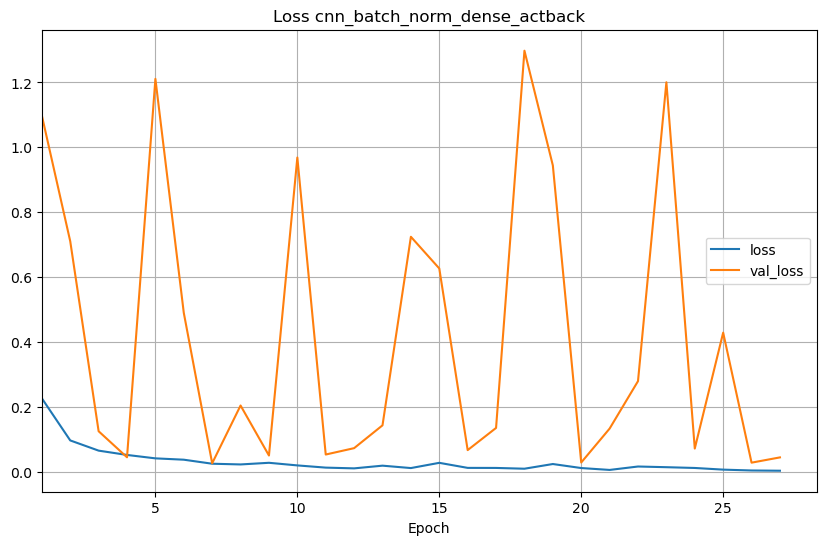

In [58]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

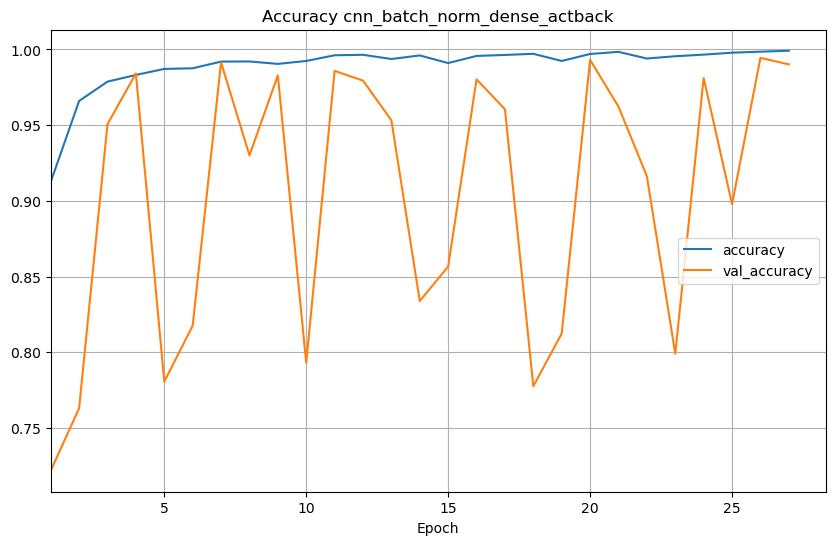

In [59]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [60]:
# Predict test set labels
y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

91/91 [==============================] - 1s 12ms/step
Accuracy: 0.98901


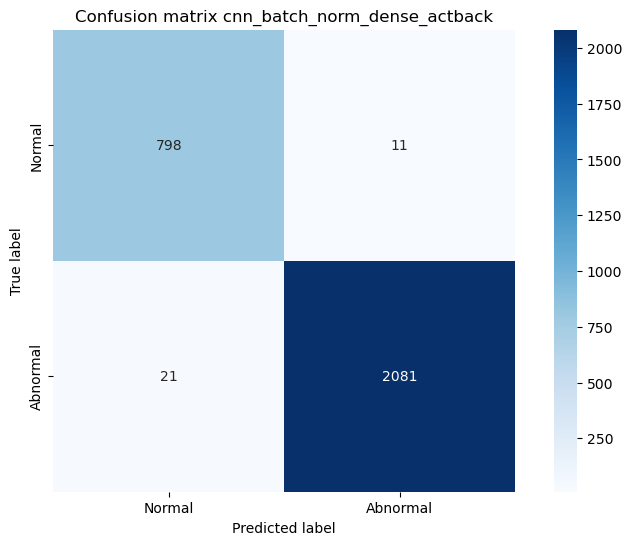

In [61]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [62]:
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9744    0.9864    0.9803       809
    Abnormal     0.9947    0.9900    0.9924      2102

    accuracy                         0.9890      2911
   macro avg     0.9846    0.9882    0.9864      2911
weighted avg     0.9891    0.9890    0.9890      2911



# Dropout with Rate 0.10

In [18]:
name = 'cnn_dropout_010'

In [19]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
        model.add(tf.keras.layers.BatchNormalization())
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(rate=0.1))
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons))
    model.add(tf.keras.layers.Activation('relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 12s 38ms/step - loss: 0.2694 - accuracy: 0.8827 - val_loss: 1.7272 - val_accuracy: 0.7218
Epoch 2/100
291/291 [==============================] - 10s 34ms/step - loss: 0.1209 - accuracy: 0.9538 - val_loss: 1.2785 - val_accuracy: 0.7677
Epoch 3/100
291/291 [==============================] - 10s 34ms/step - loss: 0.0833 - accuracy: 0.9721 - val_loss: 0.1948 - val_accuracy: 0.9352
Epoch 4/100
291/291 [==============================] - 9s 31ms/step - loss: 0.0706 - accuracy: 0.9759 - val_loss: 0.1353 - val_accuracy: 0.9601
Epoch 5/100
291/291 [==============================] - 10s 33ms/step - loss: 0.0491 - accuracy: 0.9831 - val_loss: 0.0539 - val_accuracy: 0.9807
Epoch 6/100
291/291 [==============================] - 10s 34ms/step - loss: 0.0373 - accuracy: 0.9885 - val_loss: 0.4773 - val_accuracy: 0.8540
Epoch 7/100
291/291 [==============================] - 10s 33ms/step - loss: 0.0522 - accuracy: 0.9854 - val_loss: 0.5131 - val_acc

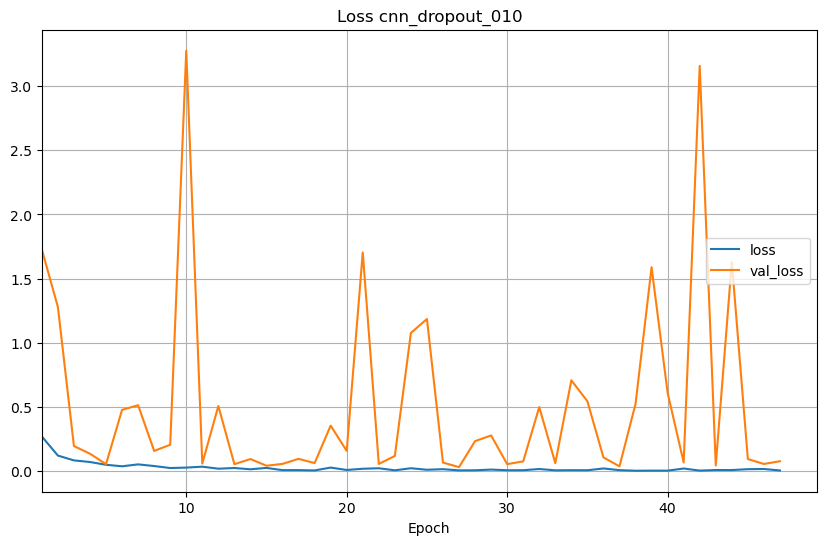

In [21]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

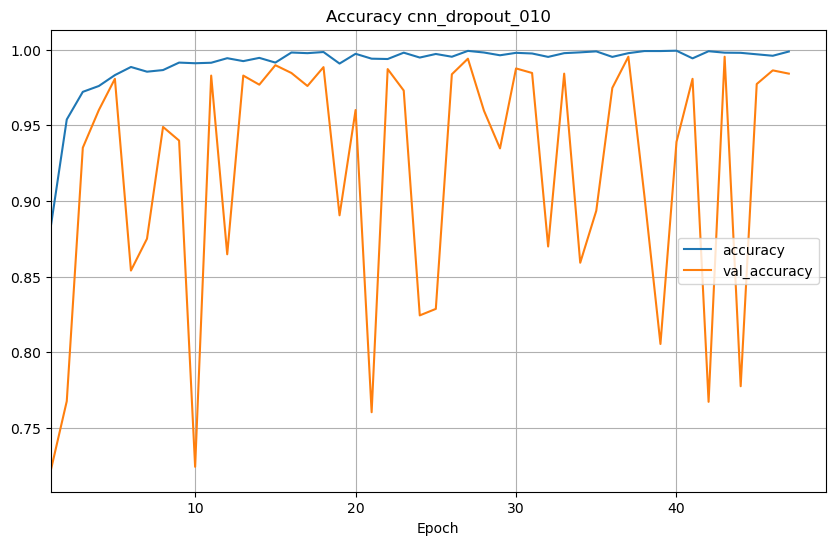

In [22]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [23]:
# Predict test set labels
y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

91/91 [==============================] - 1s 14ms/step
Accuracy: 0.99244


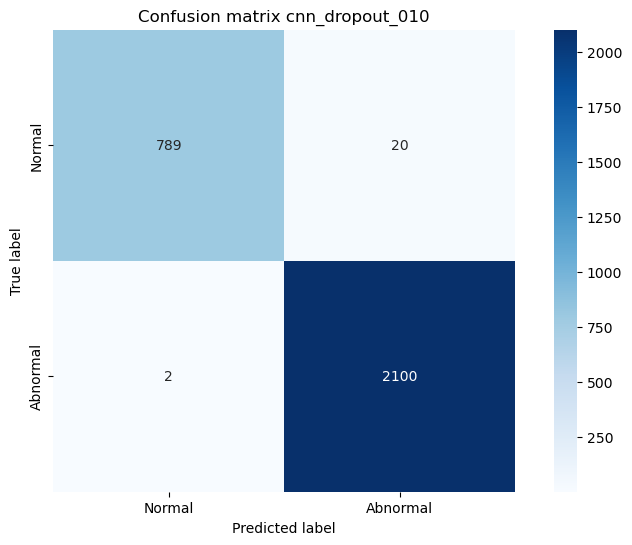

In [24]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [25]:
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9975    0.9753    0.9862       809
    Abnormal     0.9906    0.9990    0.9948      2102

    accuracy                         0.9924      2911
   macro avg     0.9940    0.9872    0.9905      2911
weighted avg     0.9925    0.9924    0.9924      2911



# Dropout with Rate 0.08

In [26]:
name = 'cnn_dropout_008'

In [27]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
        model.add(tf.keras.layers.BatchNormalization())
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(rate=0.08))
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons))
    model.add(tf.keras.layers.Activation('relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 12s 37ms/step - loss: 0.2599 - accuracy: 0.8915 - val_loss: 1.0410 - val_accuracy: 0.7218
Epoch 2/100
291/291 [==============================] - 10s 34ms/step - loss: 0.1152 - accuracy: 0.9577 - val_loss: 0.4435 - val_accuracy: 0.8411
Epoch 3/100
291/291 [==============================] - 10s 35ms/step - loss: 0.0771 - accuracy: 0.9750 - val_loss: 0.1767 - val_accuracy: 0.9373
Epoch 4/100
291/291 [==============================] - 10s 35ms/step - loss: 0.0610 - accuracy: 0.9777 - val_loss: 0.4074 - val_accuracy: 0.8793
Epoch 5/100
291/291 [==============================] - 10s 34ms/step - loss: 0.0541 - accuracy: 0.9820 - val_loss: 0.6348 - val_accuracy: 0.8463
Epoch 6/100
291/291 [==============================] - 10s 35ms/step - loss: 0.0403 - accuracy: 0.9874 - val_loss: 0.0478 - val_accuracy: 0.9854
Epoch 7/100
291/291 [==============================] - 11s 36ms/step - loss: 0.0249 - accuracy: 0.9925 - val_loss: 0.2235 - val_ac

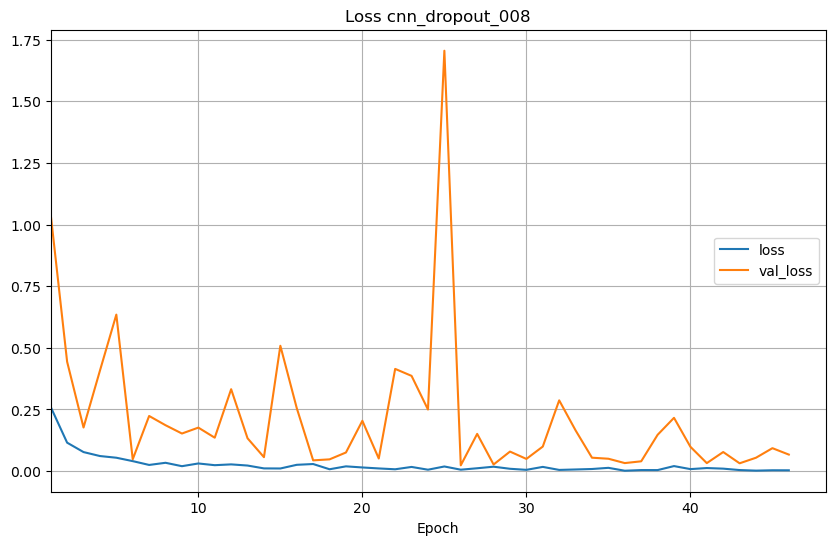

In [29]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

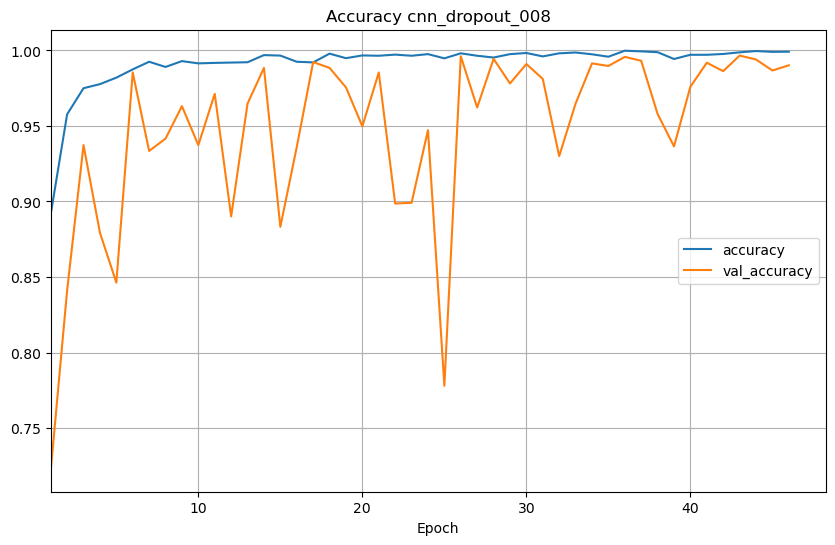

In [30]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [31]:
# Predict test set labels
y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

91/91 [==============================] - 1s 14ms/step
Accuracy: 0.99107


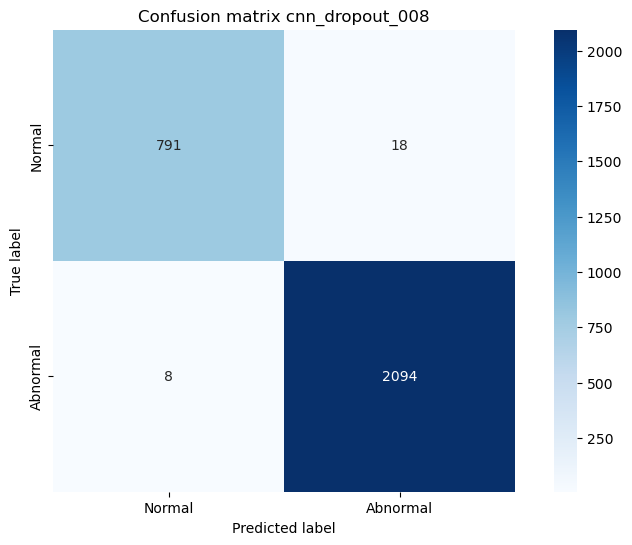

In [32]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [33]:
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9900    0.9778    0.9838       809
    Abnormal     0.9915    0.9962    0.9938      2102

    accuracy                         0.9911      2911
   macro avg     0.9907    0.9870    0.9888      2911
weighted avg     0.9911    0.9911    0.9911      2911



# Dropout with Rate 0.12

In [34]:
name = 'cnn_dropout_012'

In [35]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
        model.add(tf.keras.layers.BatchNormalization())
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(rate=0.12))
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons))
    model.add(tf.keras.layers.Activation('relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 12s 37ms/step - loss: 0.2995 - accuracy: 0.8804 - val_loss: 1.0907 - val_accuracy: 0.7218
Epoch 2/100
291/291 [==============================] - 11s 36ms/step - loss: 0.1445 - accuracy: 0.9425 - val_loss: 0.5980 - val_accuracy: 0.8085
Epoch 3/100
291/291 [==============================] - 11s 37ms/step - loss: 0.0984 - accuracy: 0.9638 - val_loss: 0.2115 - val_accuracy: 0.9154
Epoch 4/100
291/291 [==============================] - 10s 36ms/step - loss: 0.0753 - accuracy: 0.9730 - val_loss: 1.1161 - val_accuracy: 0.7364
Epoch 5/100
291/291 [==============================] - 11s 37ms/step - loss: 0.0581 - accuracy: 0.9805 - val_loss: 0.2377 - val_accuracy: 0.9171
Epoch 6/100
291/291 [==============================] - 11s 36ms/step - loss: 0.0475 - accuracy: 0.9838 - val_loss: 0.3251 - val_accuracy: 0.8927
Epoch 7/100
291/291 [==============================] - 11s 37ms/step - loss: 0.0398 - accuracy: 0.9857 - val_loss: 0.0959 - val_ac

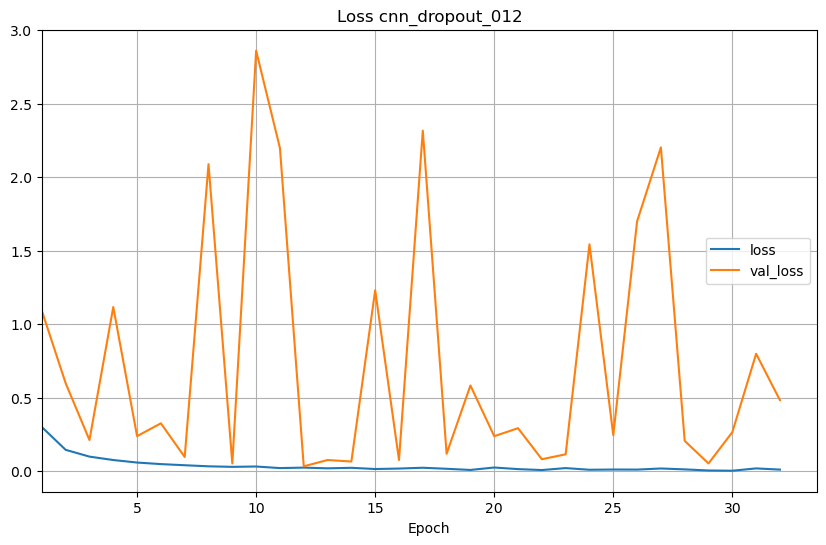

In [37]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

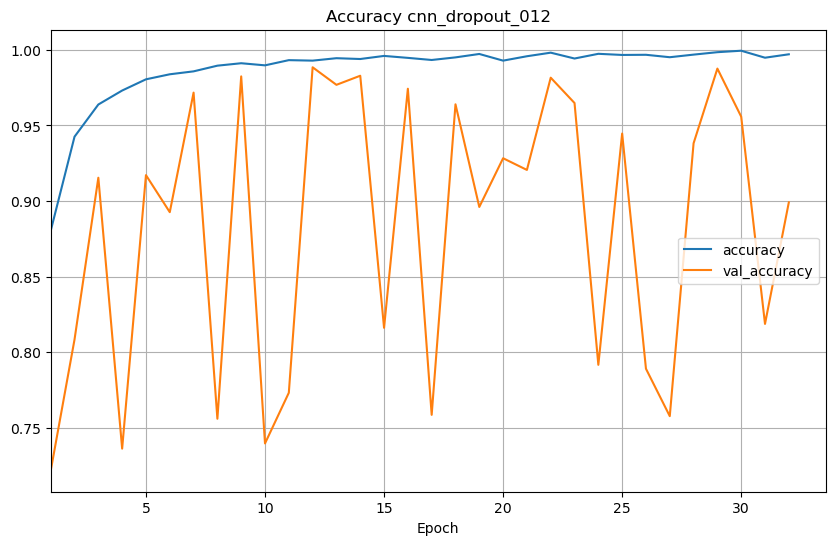

In [38]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [39]:
# Predict test set labels
y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

91/91 [==============================] - 2s 16ms/step
Accuracy: 0.98454


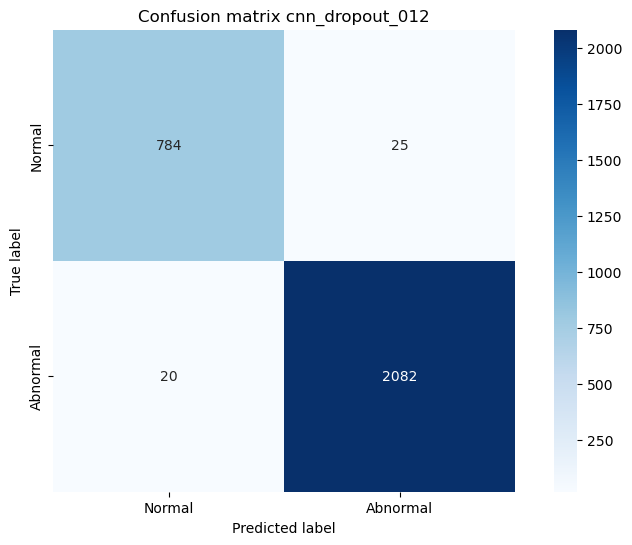

In [40]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,6))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [41]:
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9751    0.9691    0.9721       809
    Abnormal     0.9881    0.9905    0.9893      2102

    accuracy                         0.9845      2911
   macro avg     0.9816    0.9798    0.9807      2911
weighted avg     0.9845    0.9845    0.9845      2911

